<a href="https://colab.research.google.com/github/hanghae-plus-AI/AI-1-soyoungcareer/blob/main/week1/Chapter1_1_%EC%8B%AC%ED%99%94%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 과제 수행 순서
    1. Dataset 및 activation 함수 변경
        1. Dataset CIFAR10으로 변경
        2. Activation 함수 LeakyReLU로 변경
        3. 학습인자 변경 (`n_epochs` = 50, `batch_size` = 256)
    2. CIFAR10의 입력 shape 확인
        1. shape 확인
        2. shape 확인 후 수정
    3. SGD와 Adam 성능 비교
        1. Adam import
        2. Adam optimizer 정의
        3. SGD vs Adam 시각화 함수 정의
    4. Leaky ReLU와 Sigmoid 성능 비교
        1. Sigmoid class 정의
        2. Sigmoid Adam optimizer 정의
        3. Sigmoid vs LeakyReLU 시각화 함수 정의
        4. 모델과 옵티마이저 초기화
    5. Dropout을 적용한 이후의 generalization error 확인
        1. Dropout class 정의
        2. Dropout 추가
        3. Dropout 시각화 함수 정의
        4. 옵티마이저 초기화

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import SGD, Adam    # 3-a. Adam import

In [ ]:
transform = transforms.ToTensor()

# 1-a. Dataset CIFAR10으로 변경
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 170498071/170498071 [00:03<00:00, 49175310.51it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


50000
torch.Size([3, 32, 32]) 6


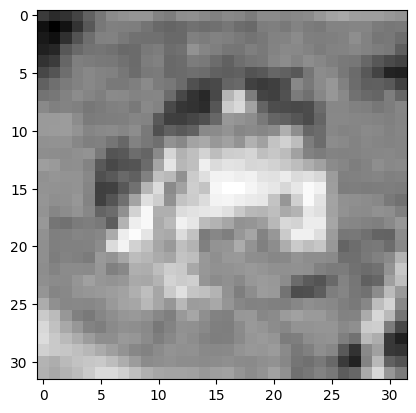

In [ ]:
# 2-a. shape 확인
print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

In [ ]:
batch_size = 256
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


In [ ]:
# (1) LeakyReLU model
class Model_leaky(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)  # 출력 차원 10으로 변경 (0~9)

    self.act = nn.LeakyReLU()    # 1-b. Activation 함수 변경

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)    # 데이터 평탄화
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x

model_leaky = Model_leaky(3 * 32 * 32, 1024)    # 2-b .shape 확인 후 수정


# (2) 4-a. Sigmoid model
class Model_sig(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)  # 출력 차원 10으로 변경 (0~9)

    self.act = nn.Sigmoid()    # 1-b. Activation 함수 변경

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)    # 데이터 평탄화
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x

model_sig = Model_sig(3 * 32 * 32, 1024)    # 2-b. shape 확인 후 수정


# (3) 5-1. Dropout model
class Model_drop(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)  # 출력 차원 10으로 변경 (0~9)

    self.act = nn.LeakyReLU()    # 1-b. Activation 함수 변경
    self.dropout = nn.Dropout(0.1)    # 5-b. Dropout 비율 추가 (10%의 뉴런을 무작위로 비활성화)

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)    # 데이터 평탄화
    x = self.act(self.layer1(x))
    x = self.dropout(x)    # 5-b. layer 사이에 dropout 적용 (활성화 값 중 일부를 학습 시 무작위로 제거하여 과적합 방지)
    x = self.act(self.layer2(x))
    x = self.dropout(x)    # 5-b. layer 사이에 dropout 적용
    x = self.layer3(x)

    return x

model_drop = Model_drop(3 * 32 * 32, 1024)    # 2-b. shape 확인 후 수정


In [ ]:
lr = 0.001
model_leaky = model_leaky.to('cuda')
model_sig = model_sig.to('cuda')
model_drop = model_drop.to('cuda')

# 옵티마이저 정의
optimizer_sgd = SGD(model_leaky.parameters(), lr=lr)    # SGD
optimizer_adam = Adam(model_leaky.parameters(), lr=lr)    # 3-b. Adam optimizer 정의

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

In [ ]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

# (1) 3-c. SGD vs Adam 시각화 함수 정의
def plot_acc_sgdAdam(train_accs_sgd, test_accs_sgd, train_accs_adam, test_accs_adam):
  x = np.arange(len(train_accs_sgd))

  plt.plot(x, train_accs_sgd, label='train_sgd')
  plt.plot(x, test_accs_sgd, label='test_sgd')
  plt.plot(x, train_accs_adam, label='train_adam')
  plt.plot(x, test_accs_adam, label='test_adam')
  plt.legend()
  plt.show()

# (2) 4-c. Sigmoid vs LeakyReLU 시각화 함수 정의
def plot_acc_sigLeaky(train_accs_sig, test_accs_sig, train_accs_leaky, test_accs_leaky):
  x = np.arange(len(train_accs_sig))

  plt.plot(x, train_accs_sig, label='train_sig')
  plt.plot(x, test_accs_sig, label='test_sig')
  plt.plot(x, train_accs_leaky, label='train_leaky')
  plt.plot(x, test_accs_leaky, label='test_leaky')
  plt.legend()
  plt.show()

# (3) 5-c. Dropout 시각화 함수 정의
def plot_acc_drop(train_accs_drop, test_accs_drop):
  x = np.arange(len(train_accs_drop))

  plt.plot(x, train_accs_drop, label='train_drop')
  plt.plot(x, test_accs_drop, label='test_drop')
  plt.legend()
  plt.show()

# 학습 및 평가 함수 정의
def trainEval(model, criterion, trainloader, testloader, optimizer):
  n_epochs = 50    # 1-c. 학습 인자 변경
  train_accuracies = []
  test_accuracies = []

  for epoch in range(n_epochs):
      total_loss = 0.

      # train
      model.train()
      for data in trainloader:
          model.zero_grad()
          inputs, labels = data
          inputs, labels = inputs.to('cuda'), labels.to('cuda')

          preds = model(inputs)
          loss = criterion(preds, labels)  # 손실 계산
          loss.backward()    # 역전파 (손실에 대한 기울기 계산)
          optimizer.step()    # 기울기를 바탕으로 모델의 가중치(파라미터) 업데이트

          total_loss += loss.item()

      print(f"Epoch {epoch:3d} | Loss: {total_loss}")
      train_accuracy = accuracy(model, trainloader)
      train_accuracies.append(train_accuracy)

      # eval
      model.eval()
      with torch.no_grad():
          test_accuracy = accuracy(model, testloader)
          test_accuracies.append(test_accuracy)

  return train_accuracies, test_accuracies


Epoch   0 | Loss: 450.2618508338928
Epoch   1 | Loss: 448.0467667579651
Epoch   2 | Loss: 446.20228266716003
Epoch   3 | Loss: 444.4129259586334
Epoch   4 | Loss: 442.53011775016785
Epoch   5 | Loss: 440.51592683792114
Epoch   6 | Loss: 438.3516125679016
Epoch   7 | Loss: 436.00020003318787
Epoch   8 | Loss: 433.47893381118774
Epoch   9 | Loss: 430.7532916069031
Epoch  10 | Loss: 427.90997076034546
Epoch  11 | Loss: 425.0072822570801
Epoch  12 | Loss: 422.00392746925354
Epoch  13 | Loss: 419.0476620197296
Epoch  14 | Loss: 416.1855218410492
Epoch  15 | Loss: 413.51096653938293
Epoch  16 | Loss: 410.89675211906433
Epoch  17 | Loss: 408.48598408699036
Epoch  18 | Loss: 406.2539496421814
Epoch  19 | Loss: 404.13644444942474
Epoch  20 | Loss: 402.15021193027496
Epoch  21 | Loss: 400.2381782531738
Epoch  22 | Loss: 398.4419277906418
Epoch  23 | Loss: 396.694433927536
Epoch  24 | Loss: 395.18900656700134
Epoch  25 | Loss: 393.5504387617111
Epoch  26 | Loss: 392.0412415266037
Epoch  27 | Loss

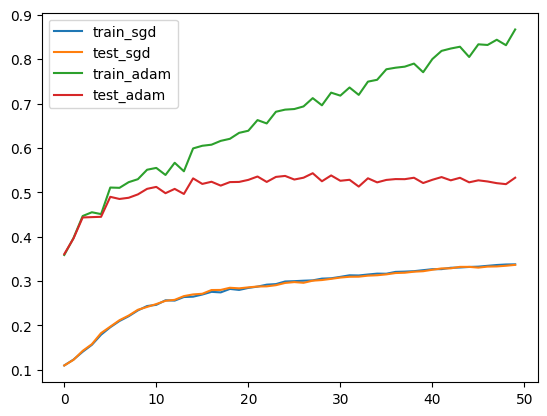

In [ ]:
# (plot1) SGD vs Adam
train_accs_sgd, test_accs_sgd = trainEval(model_leaky, criterion, trainloader, testloader, optimizer_sgd)
train_accs_adam, test_accs_adam = trainEval(model_leaky, criterion, trainloader, testloader, optimizer_adam)

plot_acc_sgdAdam(train_accs_sgd, test_accs_sgd, train_accs_adam, test_accs_adam)

Epoch   0 | Loss: 145.75831645727158
Epoch   1 | Loss: 140.53678011894226
Epoch   2 | Loss: 139.84895020723343
Epoch   3 | Loss: 135.63525593280792
Epoch   4 | Loss: 135.4564794898033
Epoch   5 | Loss: 132.30619025230408
Epoch   6 | Loss: 130.8510216474533
Epoch   7 | Loss: 128.1368551850319
Epoch   8 | Loss: 123.78348463773727
Epoch   9 | Loss: 123.30314001441002
Epoch  10 | Loss: 123.60328727960587
Epoch  11 | Loss: 119.11282268166542
Epoch  12 | Loss: 117.07093298435211
Epoch  13 | Loss: 116.04194286465645
Epoch  14 | Loss: 114.57661792635918
Epoch  15 | Loss: 111.30883979797363
Epoch  16 | Loss: 108.86829477548599
Epoch  17 | Loss: 109.1190242767334
Epoch  18 | Loss: 102.72426944971085
Epoch  19 | Loss: 104.92919120192528
Epoch  20 | Loss: 102.3233251273632
Epoch  21 | Loss: 100.02986949682236
Epoch  22 | Loss: 100.69452396035194
Epoch  23 | Loss: 94.29524567723274
Epoch  24 | Loss: 93.0438626408577
Epoch  25 | Loss: 94.85179340839386
Epoch  26 | Loss: 91.41841572523117
Epoch  27 |

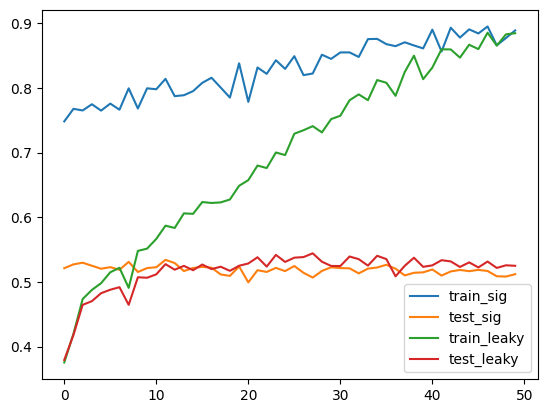

In [ ]:
# (plot2) Sigmoid vs LeakyReLU

# 4-b. Sigmoid Adam optimizer 정의
optimizer_adam_sig = Adam(model_sig.parameters(), lr=lr)

# 4-d. 모델과 옵티마이저 초기화
model_leaky = Model_leaky(3 * 32 * 32, 1024).to('cuda')
optimizer_adam = Adam(model_leaky.parameters(), lr=lr)


train_accs_sig, test_accs_sig = trainEval(model_sig, criterion, trainloader, testloader, optimizer_adam_sig)
train_accs_leaky, test_accs_leaky = trainEval(model_leaky, criterion, trainloader, testloader, optimizer_adam)

plot_acc_sigLeaky(train_accs_sig, test_accs_sig, train_accs_leaky, test_accs_leaky)

Epoch   0 | Loss: 371.0384874343872
Epoch   1 | Loss: 331.06009101867676
Epoch   2 | Loss: 314.65089416503906
Epoch   3 | Loss: 305.8680155277252
Epoch   4 | Loss: 297.843222618103
Epoch   5 | Loss: 290.64135098457336
Epoch   6 | Loss: 286.0780303478241
Epoch   7 | Loss: 279.42532074451447
Epoch   8 | Loss: 277.1013069152832
Epoch   9 | Loss: 270.8443192243576
Epoch  10 | Loss: 265.9866975545883
Epoch  11 | Loss: 263.5596249103546
Epoch  12 | Loss: 259.287829041481
Epoch  13 | Loss: 254.93703472614288
Epoch  14 | Loss: 251.14290976524353
Epoch  15 | Loss: 247.64242804050446
Epoch  16 | Loss: 243.95604979991913
Epoch  17 | Loss: 241.90616416931152
Epoch  18 | Loss: 238.9749584197998
Epoch  19 | Loss: 237.42328119277954
Epoch  20 | Loss: 230.9618011713028
Epoch  21 | Loss: 229.37512171268463
Epoch  22 | Loss: 224.7146869301796
Epoch  23 | Loss: 223.022055208683
Epoch  24 | Loss: 221.14731526374817
Epoch  25 | Loss: 216.48298680782318
Epoch  26 | Loss: 212.64257442951202
Epoch  27 | Loss:

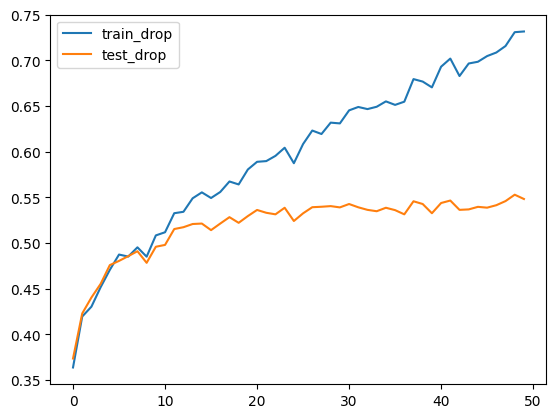

In [ ]:
# (plot3) Dropout with Adam

# 5-d. 옵티마이저 초기화
optimizer_adam = Adam(model_drop.parameters(), lr=lr)

train_accs_drop, test_accs_drop = trainEval(model_drop, criterion, trainloader, testloader, optimizer_adam)

plot_acc_drop(train_accs_drop, test_accs_drop)

- 과제 수행 시 수정사항
    - trainEval 함수에서 리턴값 수정 (오타)
        - (기존) train_accuracies, train_accuracies → (변경) train_accuracies, test_accuracies
    - (plot2) Sigmoid vs LeakyReLU
        - trainEval 함수에 모델을 sig로 넣지 않음 (오타)
            - (기존) train_accs_sig, test_accs_sig = trainEval(model_leaky, criterion, trainloader, testloader, optimizer_adam)
            - (변경) train_accs_sig, test_accs_sig = trainEval(model_sig, criterion, trainloader, testloader, optimizer_adam)
        - optimizer 을 sigmoid, leaky 따로 만들어줘야 함.
            - optimizer_adam_sig 추가
                
                ```python
                optimizer_adam = Adam(model_leaky.parameters(), lr=lr)    
                optimizer_adam_sig = Adam(model_sig.parameters(), lr=lr)    
                ```
                
        - model, optimizer 초기화
            - 문제현상 : leaky 모델로 trainEval 함수 실행 시, loss가 매우 큰 값이 나옴.
            - 초기화하지 않은 상태로 기존 학습된 모델, 옵티마이저를 쓰는 경우 이전에 업데이트된 가중치와 옵티마이저 그대로 사용하게 됨.